# Speech emotion recognition and recommendation of music using FNN with Self-Attention model

In this experiment i tried to recognize emotion in short voice message (< 3s). I will use 1 dataset with some english phrases,which were voiced by professional actor Tess.

#### First, lets define SER i.e. Speech Emotion Recognition.

*Speech Emotion Recognition*, abbreviated as *SER*, is the act of attempting to recognize human emotion and affective states from speech.
This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon
that animals like dogs and horses employ to be able to understand human emotion

**Dataset used in this project** contains ~7 types of main emotions: *Happy, Fear, Angry, Disgust, Surprised, Sad or Neutral.* 


## Importing libraries

In [1]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
# from entropy import spectral_entropy
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import itertools

In [2]:
# Path to
Tess = "../input/speech-emotion-recognition-en/Tess"

## Data preparation

### TESS dataset

In [3]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


Tess_df = pd.DataFrame.from_dict(emotion_df)
Tess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Tess_df.head()

,Emotion,Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [4]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Tess_df], axis=0)
df.shape

(2800, 2)

In [5]:
df.head(10)

,Emotion,Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...
5,fear,../input/speech-emotion-recognition-en/Tess/YA...
6,fear,../input/speech-emotion-recognition-en/Tess/YA...
7,fear,../input/speech-emotion-recognition-en/Tess/YA...
8,fear,../input/speech-emotion-recognition-en/Tess/YA...
9,fear,../input/speech-emotion-recognition-en/Tess/YA...


### Due to i don't split the dataset by gender, let's look at distribution by


In [6]:
%matplotlib inline

plt.style.use("ggplot")

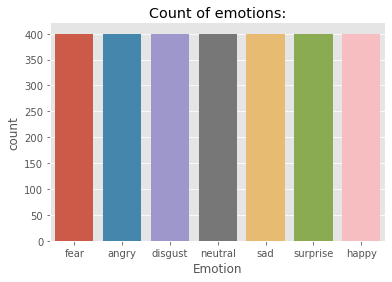

In [7]:
plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

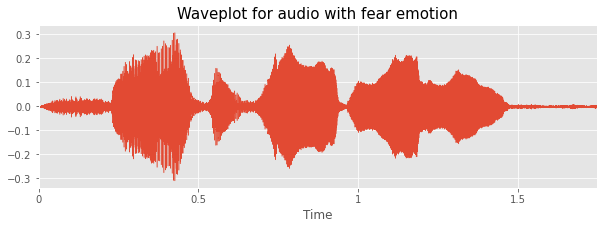

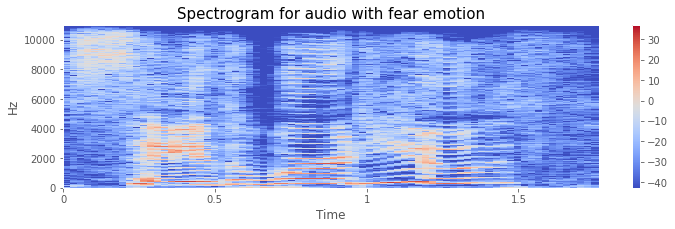

In [9]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)


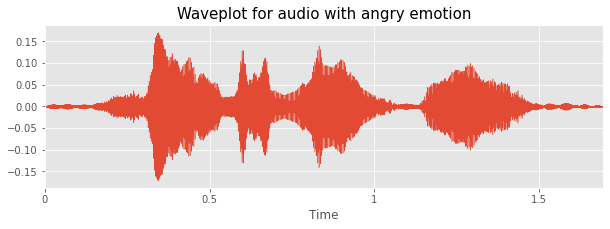

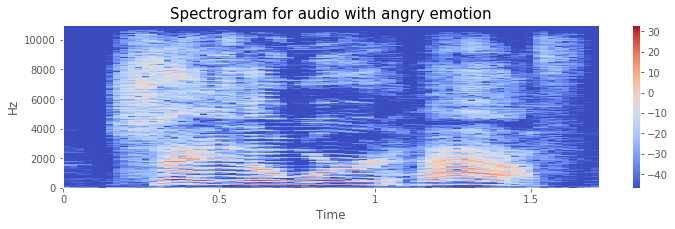

In [10]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

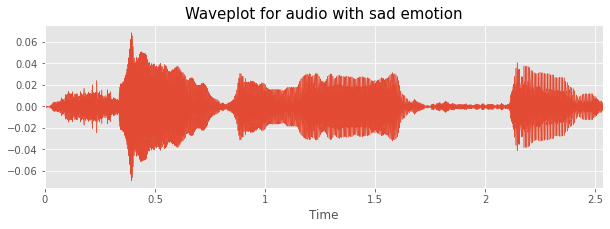

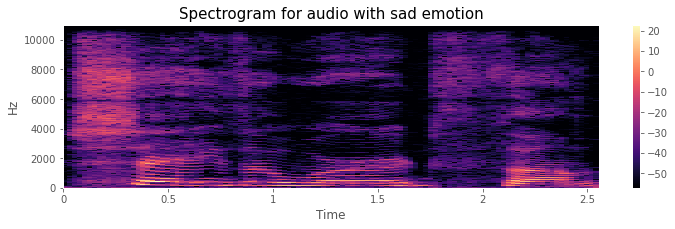

In [11]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data augmentation

We have some ways for data augmentation in sound data:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

In [12]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [13]:
df.head()

,Emotion,Path
0,fear,../input/speech-emotion-recognition-en/Tess/YA...
1,fear,../input/speech-emotion-recognition-en/Tess/YA...
2,fear,../input/speech-emotion-recognition-en/Tess/YA...
3,fear,../input/speech-emotion-recognition-en/Tess/YA...
4,fear,../input/speech-emotion-recognition-en/Tess/YA...


In [14]:
path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple audio

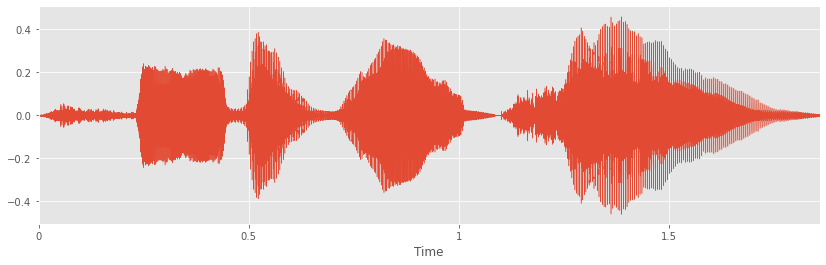

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

2. Noised audio

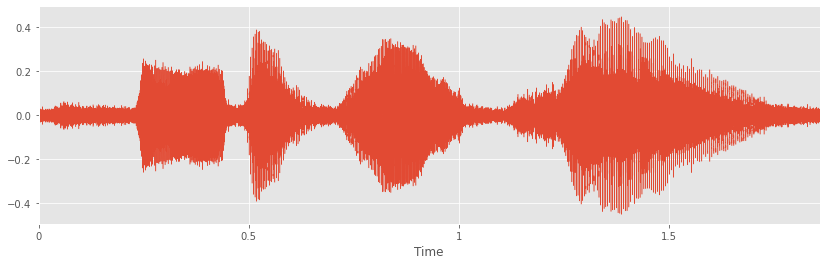

In [16]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)


3. Stretching


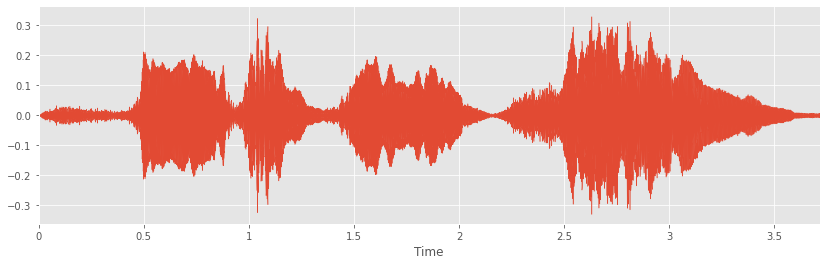

In [17]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)


4. Shifting


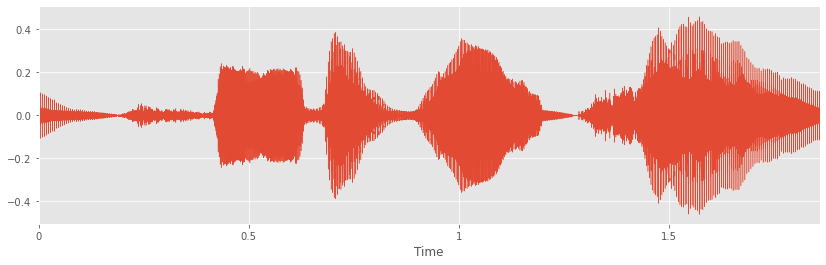

In [18]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)


5. Pitching

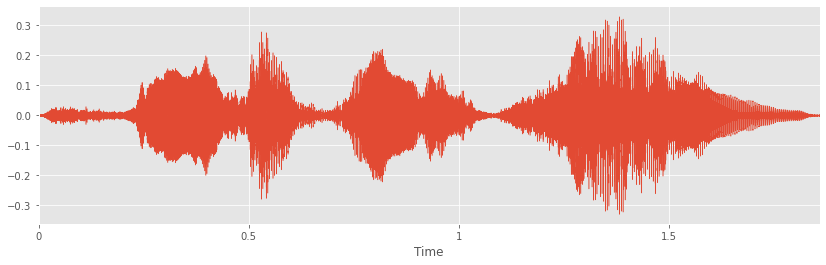

In [19]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

For our data augmentation we will use noise and pitch and combination with both of it.


## Feature extraction

#### There are some features may be useful:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
3. Spectral Centroid : The center of gravity of the spectrum.
4. Spectral Spread : The second central moment of the spectrum.
5. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
6. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
7. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
8. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [20]:
n_fft = 2048
hop_length = 512

In [21]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

#### Let's check data formats:

In [22]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

40071

In [23]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
# print("Spectral Entropy: ", spc_entropy(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)


ZCR:  (79,)
Energy:  (79,)
Entropy of Energy : (79,)
RMS : (79,)
Spectral Centroid : (79,)
Spectral Flux:  ()
Spectral Rollof:  (79,)
Chroma STFT:  (948,)
MelSpectrogram:  (10112,)
MFCC:  (1580,)


In experimental way was decided to use just 3 main features for this task: *ZCR*, *RMS* and *MFCC*.

Also in experimental way  was decided to use just 2.5s duration with 0.6 offset - in the dataset first 0.6s contains
no information about emotion, and most of them are less then 3s.

In [24]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [25]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [26]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
1500 samples has been processed...
1600 samples has been processed...
1700 samples has been processed...
1800 samples has been processed...
1900 samples has been processed...
2000 samples has been processed...
2100 samples has been processed...
2200 samples has been processed...
2300 samples has been processed...
2400 samples has been processed...
2500 samples has been processed...
2600 samples has been processed...
2700 samples has been processed...
Done.


Let's save our features as DataFrame for further processing:

In [27]:
features_path = "./features.csv"

In [28]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2257,2258,2259,2260,2261,2262,2263,2264,2265,labels
0,0.028809,0.051758,0.071777,0.066895,0.075684,0.078613,0.073730,0.082520,0.070312,0.060059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
1,0.029785,0.055664,0.077637,0.074707,0.085449,0.085449,0.080566,0.086426,0.076172,0.073730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
2,0.033691,0.045410,0.056641,0.063965,0.061035,0.061035,0.081055,0.078613,0.073730,0.076172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
3,0.033203,0.044922,0.055176,0.062500,0.060059,0.062988,0.079590,0.075684,0.071289,0.067871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fear


In [29]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(11200, 2267)


In [30]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape


0         False
1         False
2         False
3         False
4         False
          ...  
2262      False
2263      False
2264      False
2265      False
labels    False
Length: 2267, dtype: bool


(11200, 2267)

In [31]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2257,2258,2259,2260,2261,2262,2263,2264,2265,labels
0,0.028809,0.051758,0.071777,0.066895,0.075684,0.078613,0.073730,0.082520,0.070312,0.060059,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
1,0.029785,0.055664,0.077637,0.074707,0.085449,0.085449,0.080566,0.086426,0.076172,0.073730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
2,0.033691,0.045410,0.056641,0.063965,0.061035,0.061035,0.081055,0.078613,0.073730,0.076172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
3,0.033203,0.044922,0.055176,0.062500,0.060059,0.062988,0.079590,0.075684,0.071289,0.067871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
4,0.020508,0.027344,0.038086,0.036133,0.035645,0.046387,0.061035,0.084473,0.104004,0.116699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear


## Data preparation

As of now we have extracted the data, now we need to normalize and split our data for training and testing.


In [32]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [33]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y


['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8960, 2266), (2240, 2266), (8960, 7), (2240, 7))

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((8064, 2266), (2240, 2266), (896, 2266), (8064, 7), (2240, 7), (896, 7))

In [36]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((8064, 2266), (2240, 2266), (896, 2266), (8064, 7), (2240, 7), (896, 7))

In [37]:
# We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(8064, 2266, 1)

### Let's define our model:

In [106]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)


In [107]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [108]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [109]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the FNN with Self-Attention model
def create_fnn_self_attention_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Flatten the input
    x = layers.Flatten()(inputs)

    # Fully connected layers
    x = layers.Dense(2048, activation='relu')(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)

    # Self-attention mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(64)(attention)
    attention = layers.Permute([2, 1])(attention)
    x = layers.Multiply()([x, attention])
    x = layers.Lambda(lambda v: keras.backend.sum(v, axis=1))(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

input_shape = (X_train.shape[1],)
num_classes = 7

model = create_fnn_self_attention_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2266)]       0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 2266)         0           input_4[0][0]                    
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 2048)         4642816     flatten_6[0][0]                  
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 1024)         2098176     dense_24[0][0]                   
_______________________________________________________________________________________

In [110]:
EPOCHS = 50
batch_size = 64

In [111]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=EPOCHS, batch_size=batch_size,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
126/126 [==============================] - 1s 5ms/step - loss: 1.2677 - accuracy: 0.4803 - val_loss: 1.0157 - val_accuracy: 0.5636
Epoch 2/50
126/126 [==============================] - 0s 3ms/step - loss: 0.7658 - accuracy: 0.7029 - val_loss: 0.7959 - val_accuracy: 0.7098
Epoch 3/50
126/126 [==============================] - 0s 3ms/step - loss: 0.5498 - accuracy: 0.8008 - val_loss: 0.5414 - val_accuracy: 0.7991
Epoch 4/50
126/126 [==============================] - 0s 3ms/step - loss: 0.3593 - accuracy: 0.8699 - val_loss: 0.3936 - val_accuracy: 0.8638
Epoch 5/50
126/126 [==============================] - 0s 3ms/step - loss: 0.2908 - accuracy: 0.8973 - val_loss: 0.2805 - val_accuracy: 0.9029
Epoch 6/50
126/126 [==============================] - 0s 4ms/step - loss: 0.2254 - accuracy: 0.9225 - val_loss: 0.3151 - val_accuracy: 0.8906
Epoch 7/50
126/126 [==============================] - 0s 3ms/step - loss: 0.1905 - accuracy: 0.9368 - val_loss: 0.2290 - val_accuracy: 0.9185
Epoch 

70/70 [==============================] - 0s 2ms/step - loss: 0.1080 - accuracy: 0.9857
Accuracy of our model on test data:  98.57142567634583 %


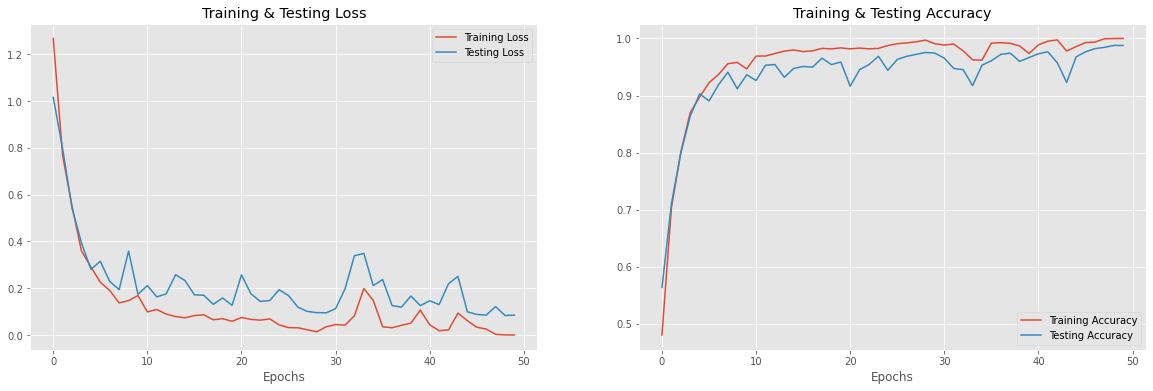

In [112]:
print("Accuracy of our model on test data: ", model.evaluate(X_test, y_test)[1] * 100, "%")

fig, ax = plt.subplots(1, 2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20, 6)
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(test_loss, label='Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(test_acc, label='Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


In [113]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 1, 4, ..., 6, 2, 4])

In [114]:
y_check = np.argmax(y_test, axis=1)
y_check

array([4, 1, 4, ..., 6, 2, 4])

In [115]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [117]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[332   1   2   6   2   1   1]
 [  0 323   0   0   0   1   1]
 [  1   0 332   2   0   0   0]
 [  3   0   0 308   0   1   0]
 [  1   0   0   0 309   0   0]
 [  0   3   0   0   3 301   1]
 [  0   0   0   1   0   1 303]]


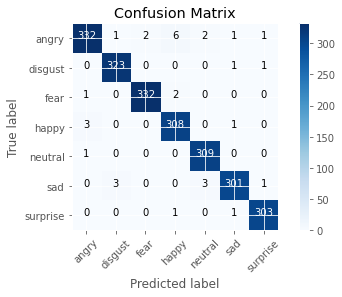

In [118]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [119]:
path_to_model = "./res_model.h5"

model.save(path_to_model)

In [51]:
from tensorflow import keras

# Path to the saved model
path_to_model = "./res_model.h5"

# Load the saved model
model = keras.models.load_model(path_to_model)


In [52]:
!pip install soundfile


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [53]:
!pip install noisereduce

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [54]:
import noisereduce as nr
import librosa
import soundfile as sf

# Set the paths for input and output audio files
input_audio_path = '/kaggle/input/input-speech/user_input_vis.wav'
output_audio_path = '/kaggle/working/noise_reduced_audio.wav'

# Load the input audio file
data, sample_rate = librosa.load(input_audio_path, sr=None)

# Perform noise reduction
reduced_noise = nr.reduce_noise(y=data, sr=sample_rate)

# Save the noise-reduced audio to the output file
sf.write(output_audio_path, reduced_noise, sample_rate)


print("Noise reduction completed successfully. Noise-reduced audio saved to:", output_audio_path)


Noise reduction completed successfully. Noise-reduced audio saved to: /kaggle/working/noise_reduced_audio.wav


In [66]:
import numpy as np
from tensorflow.keras.models import load_model
import soundfile as sf

# Set the path for the noise-reduced audio file
audio_path = '/kaggle/working/noise_reduced_audio.wav'

# Load the noise-reduced audio
data, sample_rate = sf.read(audio_path)

# Convert audio data to float32 format
data = data.astype(np.float32)

def get_features(audio_data, sample_rate):
  
    return features



In [68]:
import joblib

# Save the scaler
joblib.dump(scaler, '/kaggle/working/scaler.pkl')



['/kaggle/working/scaler.pkl']

In [73]:
import joblib

# Load the saved scaler
scaler = joblib.load('/kaggle/working/scaler.pkl')

# Check the number of features in the scaler
expected_features = scaler.mean_.shape[0]

# Reshape features to have 2 dimensions
features = features.reshape(features.shape[0], -1)

# Check if the number of features in the input matches the expected features
if features.shape[1] != expected_features:
    # Adjust the number of features in the input to match the expected features
    if features.shape[1] > expected_features:
        features = features[:, :expected_features]
    else:
        features = np.hstack((features, np.zeros((features.shape[0], expected_features - features.shape[1]))))

# Standardize the features
features = scaler.transform(features)


In [74]:
# Reshape the features to match the input shape of the model
features = np.expand_dims(features, axis=2)

# Load the saved model
model = load_model('/kaggle/working/res_model.h5')

# Predict the emotion
predictions = model.predict(features)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predicted_emotion = emotion_labels[np.argmax(predictions)]

# Print the predicted emotion
print("Predicted emotion:", predicted_emotion)

Predicted emotion: angry


In [75]:
emotion_playlist_mapping = {
    'angry': ['rock', 'metal', 'punk'],
    'disgust': ['alternative', 'indie'],
    'fear': ['ambient', 'classical', 'instrumental'],
    'happy': ['pop', 'dance', 'upbeat'],
    'neutral': ['pop', 'acoustic', 'chill'],
    'sad': ['sad', 'ballads', 'melancholic'],
    'surprise': ['electronic', 'experimental']
}

# Get the recommended playlist based on the predicted emotion
recommended_playlist = emotion_playlist_mapping.get(predicted_emotion, [])

# Print the recommended playlist
if recommended_playlist:
    print("Recommended Playlist for", predicted_emotion, ":")
    for genre in recommended_playlist:
        print("- Genre:", genre)
else:
    print("No recommended playlist found for the predicted emotion.")


Recommended Playlist for angry :
- Genre: rock
- Genre: metal
- Genre: punk


In [78]:
!pip install google-api-python-client


You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [90]:
from googleapiclient.discovery import build



In [91]:
def get_emotion_playlists(emotion):
    search_response = youtube.search().list(
        part='snippet',
        q=f'{emotion} music playlist',
        type='playlist',
        maxResults=5
    ).execute()
    
    playlists = []
    for item in search_response['items']:
        playlist = {
            'title': item['snippet']['title'],
            'playlist_id': item['id']['playlistId']
        }
        playlists.append(playlist)
    
    return playlists


In [96]:
def get_emotion_playlists(emotion):
    search_response = youtube.search().list(
        part='snippet',
        q=f'{emotion} music playlist',
        type='playlist',
        maxResults=5
    ).execute()
    
    playlists = []
    for item in search_response['items']:
        playlist = {
            'title': item['snippet']['title'],
            'playlist_id': item['id']['playlistId']
        }
        playlists.append(playlist)
    
    return playlists


In [97]:
# Predict the emotion
predictions = model.predict(features)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predicted_emotion = emotion_labels[np.argmax(predictions)]

# Print the predicted emotion
print("Predicted emotion:", predicted_emotion)

# Get recommended playlists for the predicted emotion
playlists = get_emotion_playlists(predicted_emotion)

# Print the recommended playlists
print(f"Recommended Playlist for {predicted_emotion}:")
for playlist in playlists:
    print(f"- Title: {playlist['title']}")
    print(f"  Playlist ID: {playlist['playlist_id']}")
    print(f"  YouTube Music URL: https://music.youtube.com/playlist?list={playlist['playlist_id']}")


Predicted emotion: angry
Recommended Playlist for angry:
- Title: Angry pissed off mood music
  Playlist ID: PLknqyEOvGo1YgL11BN1m-YOxaFHl29elY
  YouTube Music URL: https://music.youtube.com/playlist?list=PLknqyEOvGo1YgL11BN1m-YOxaFHl29elY
- Title: Pissed Off Rage Music
  Playlist ID: PL-PfH-O9Jvs0DpXUXX1puvpHTNXhT_NCT
  YouTube Music URL: https://music.youtube.com/playlist?list=PL-PfH-O9Jvs0DpXUXX1puvpHTNXhT_NCT
- Title: Rage Trap (@ihatebalenci)
  Playlist ID: PLhAp-0dAZtouFTqtshUZmRESySodI-evd
  YouTube Music URL: https://music.youtube.com/playlist?list=PLhAp-0dAZtouFTqtshUZmRESySodI-evd
- Title: pissed Off songs
  Playlist ID: PLzCv--w2nek1GO4fAjrfTiGIUo2VXXDbT
  YouTube Music URL: https://music.youtube.com/playlist?list=PLzCv--w2nek1GO4fAjrfTiGIUo2VXXDbT
- Title: Angry Loud Music
  Playlist ID: PL_MH8gOS_ETiNT1NF8B46JYHZe6fXWfVW
  YouTube Music URL: https://music.youtube.com/playlist?list=PL_MH8gOS_ETiNT1NF8B46JYHZe6fXWfVW
